# Введение в нейронные сети

## Урок 5. Рекуррентные нейронные сети

Используя файл Web5.ipynb (он в полезных ссылках):

Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).

Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU

In [2]:
tf.random.set_seed(1)

In [3]:
#!wget 'https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb' -O airline-passengers.csv

In [4]:
airline_passengers_data = pd.read_csv('./data/airline-passengers.csv')

In [5]:
airline_passengers_data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [6]:
airline_passengers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [7]:
airline_passengers_data['Month'].value_counts()

1949-01    1
1949-02    1
1956-09    1
1956-10    1
1956-11    1
          ..
1953-01    1
1953-02    1
1953-03    1
1953-04    1
1960-12    1
Name: Month, Length: 144, dtype: int64

Распарсим дату

In [8]:
airline_passengers_data['Month'] = pd.to_datetime(airline_passengers_data['Month'], format='%Y-%m')

In [9]:
def parse_date(df, date_feature_name):
    date_list = df[date_feature_name]
    years = []
    months = []
    for el in date_list:
        years.append(el.year)
        months.append(el.month)
    df['year'] = years
    df['mon'] = months

    return df

In [10]:
airline_passengers_data = parse_date(airline_passengers_data, 'Month')

Отбросим первый столбец, т.к. признаки [year, mon] его представляют.

In [11]:
data = airline_passengers_data.iloc[:, 1:]
data.head()

,Passengers,year,mon
0,112,1949,1
1,118,1949,2
2,132,1949,3
3,129,1949,4
4,121,1949,5


Разбиваем выборку на обучение и на тест.

In [12]:
train_size = 100


# список признаков, по которым будем учить
features = ['Passengers', 'year', 'mon']


# отступ теста от тренировки
bias = 5


# делим
train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((100, 3), (39, 3))

Создаем данные для обучения

In [13]:
features = train_data.columns[1:]
target = train_data.columns[0]

In [14]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Passengers,year,mon
0,112,-1.525724,-1.534863
1,118,-1.525724,-1.247435
2,132,-1.525724,-0.960008
3,129,-1.525724,-0.672580
4,121,-1.525724,-0.385153


Формируем параметры для генерации выборки

In [15]:
# длина истории
x_len = 3

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 8
epochs = 10

In [16]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

4 104
35 109


In [17]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 2), (100,), (35, 2), (35,))

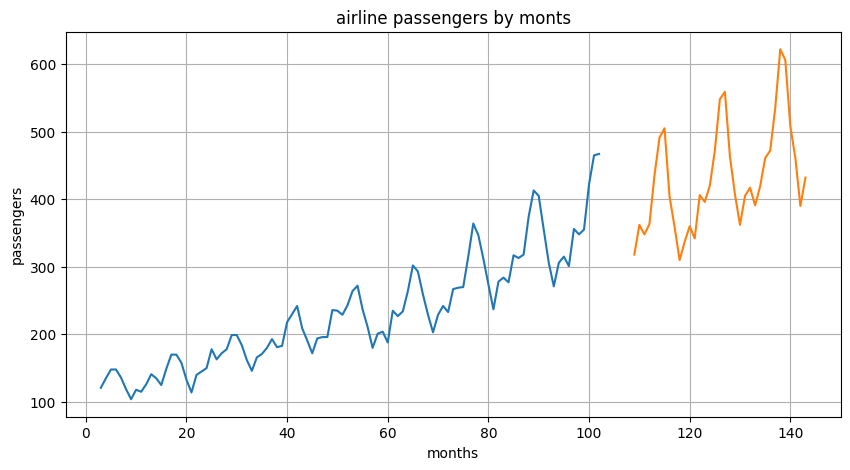

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('months')
plt.ylabel('passengers')
plt.title('airline passengers by monts')
plt.show()

In [19]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [20]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (8, 3, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]], shape=(3, 2), dtype=float64)
Target shape: (8,)
tf.Tensor(135, shape=(), dtype=int64)


In [21]:
results = pd.DataFrame() # сводная таблица результатов
model = [] # шаг
train_m = [] # результат на трейне
test_m = [] # результат на тесте

**SimpleRNN**

In [22]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_1 = Sequential()

model_1.add(SimpleRNN(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_1.add(Conv1D(64, 3, activation='linear'))
model_1.add(Conv1D(64, 1, activation='linear'))
model_1.add(Flatten())
model_1.add(Dense(3, activation='linear'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3, 32)             1120      
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             6208      
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 11,687
Trainable params: 11,687
Non-traina

In [23]:
history_1 = model_1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 2s 30ms/step - loss: 57135.1016 - mae: 226.3445 - val_loss: 196003.3906 - val_mae: 435.4684
Epoch 2/10
13/13 [==============================] - 0s 7ms/step - loss: 56386.3516 - mae: 224.7708 - val_loss: 193125.5156 - val_mae: 432.2589
Epoch 3/10
13/13 [==============================] - 0s 7ms/step - loss: 55991.1133 - mae: 224.3333 - val_loss: 190064.3125 - val_mae: 428.8505
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 55284.5938 - mae: 223.3533 - val_loss: 184839.9688 - val_mae: 422.9794
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 53723.5039 - mae: 220.9456 - val_loss: 173991.3906 - val_mae: 410.4546
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 50154.2500 - mae: 214.8630 - val_loss: 151019.3750 - val_mae: 382.3198
Epoch 7/10
13/13 [==============================] - 0s 7ms/step - loss: 42427.6016 - mae: 199.4656 - val_loss: 107239.4297 - val_mae: 321.247

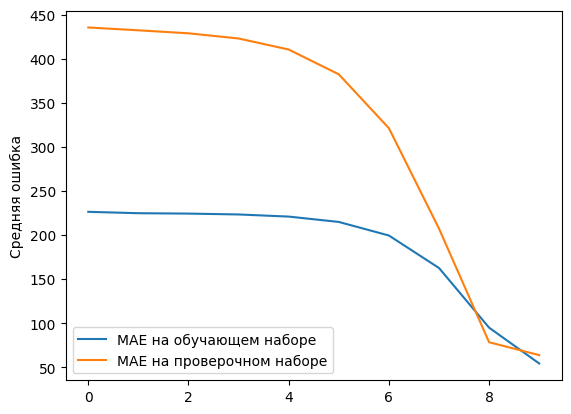

In [24]:
plt.plot(history_1.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_1.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [25]:
hist_val_1 = history_1.history['val_mae']
hist_train_1 = history_1.history['mae']

In [26]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 6ms/step - loss: 1408.1731 - mae: 29.6203 - val_loss: 12328.8955 - val_mae: 88.2368
Epoch 2/10
13/13 [==============================] - 0s 7ms/step - loss: 1077.1801 - mae: 25.7032 - val_loss: 8774.1025 - val_mae: 70.4491
Epoch 3/10
13/13 [==============================] - 0s 7ms/step - loss: 1005.6956 - mae: 25.1890 - val_loss: 8228.1270 - val_mae: 68.8941
Epoch 4/10
13/13 [==============================] - 0s 6ms/step - loss: 960.5523 - mae: 24.9802 - val_loss: 8267.6289 - val_mae: 69.6099
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 955.6719 - mae: 24.8078 - val_loss: 7983.0112 - val_mae: 68.2143
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 922.1586 - mae: 24.2468 - val_loss: 7943.1855 - val_mae: 67.9890
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 891.8893 - mae: 23.8373 - val_loss: 7684.1582 - val_mae: 66.7361
Epoch 8/10
13/13 [===================

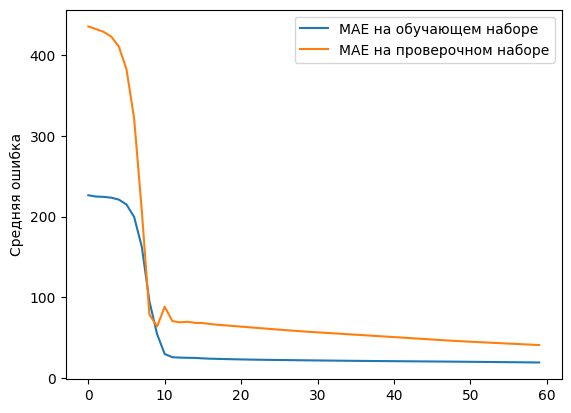

Epoch 1/10
13/13 [==============================] - 0s 7ms/step - loss: 580.5424 - mae: 19.0920 - val_loss: 3164.6189 - val_mae: 40.3008
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 576.6387 - mae: 19.0118 - val_loss: 3122.9817 - val_mae: 39.8970
Epoch 3/10
13/13 [==============================] - 0s 6ms/step - loss: 572.8752 - mae: 18.9312 - val_loss: 3084.2244 - val_mae: 39.5587
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 569.2570 - mae: 18.8508 - val_loss: 3048.2959 - val_mae: 39.2323
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 565.7871 - mae: 18.7714 - val_loss: 3015.1418 - val_mae: 38.9624
Epoch 6/10
13/13 [==============================] - 0s 7ms/step - loss: 562.4691 - mae: 18.6985 - val_loss: 2984.6880 - val_mae: 38.6996
Epoch 7/10
13/13 [==============================] - 0s 6ms/step - loss: 559.3042 - mae: 18.6262 - val_loss: 2956.8481 - val_mae: 38.4527
Epoch 8/10
13/13 [=======================

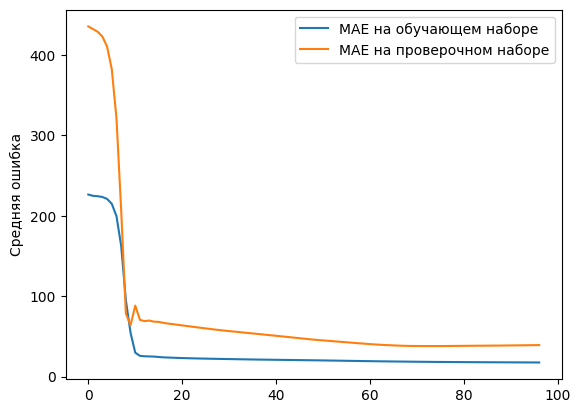

Epoch 1/10
13/13 [==============================] - 0s 8ms/step - loss: 510.3567 - mae: 17.4343 - val_loss: 2775.6321 - val_mae: 39.1485
Epoch 2/10
13/13 [==============================] - 0s 7ms/step - loss: 509.3236 - mae: 17.4097 - val_loss: 2776.7146 - val_mae: 39.2119
Epoch 3/10
13/13 [==============================] - 0s 7ms/step - loss: 508.2775 - mae: 17.3850 - val_loss: 2777.7166 - val_mae: 39.2725
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 507.2157 - mae: 17.3601 - val_loss: 2778.6211 - val_mae: 39.3304
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 506.1356 - mae: 17.3349 - val_loss: 2779.4075 - val_mae: 39.3856
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 505.0337 - mae: 17.3095 - val_loss: 2780.0542 - val_mae: 39.4381
Epoch 1/10
13/13 [==============================] - 0s 8ms/step - loss: 503.9069 - mae: 17.2836 - val_loss: 2780.5452 - val_mae: 39.4881
Epoch 2/10
13/13 [=======================

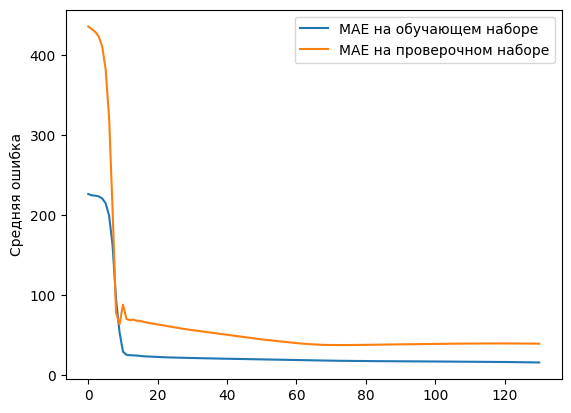

Epoch 1/10
13/13 [==============================] - 0s 7ms/step - loss: 433.5438 - mae: 16.0491 - val_loss: 2628.2114 - val_mae: 39.4976
Epoch 2/10
13/13 [==============================] - 0s 6ms/step - loss: 427.5055 - mae: 15.9542 - val_loss: 2610.4194 - val_mae: 39.4224
Epoch 3/10
13/13 [==============================] - 0s 6ms/step - loss: 420.9655 - mae: 15.8472 - val_loss: 2591.0374 - val_mae: 39.3363
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 413.8897 - mae: 15.7271 - val_loss: 2569.9470 - val_mae: 39.2383
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 406.2544 - mae: 15.5921 - val_loss: 2547.0718 - val_mae: 39.1280
Epoch 6/10
13/13 [==============================] - 0s 7ms/step - loss: 398.0310 - mae: 15.4413 - val_loss: 2522.3115 - val_mae: 39.0324
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 389.2101 - mae: 15.2730 - val_loss: 2495.6079 - val_mae: 38.9261
Epoch 8/10
13/13 [=======================

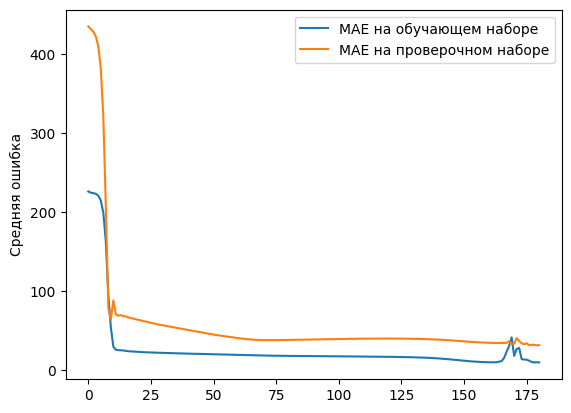

Epoch 1/10
13/13 [==============================] - 0s 7ms/step - loss: 147.3060 - mae: 9.2950 - val_loss: 1572.5454 - val_mae: 31.3939
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 147.8787 - mae: 9.3098 - val_loss: 1551.8999 - val_mae: 31.0744
Epoch 3/10
13/13 [==============================] - 0s 7ms/step - loss: 142.8193 - mae: 9.2536 - val_loss: 1526.7804 - val_mae: 31.4200
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 141.2410 - mae: 9.2160 - val_loss: 1505.1293 - val_mae: 31.2164
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 140.1689 - mae: 9.1229 - val_loss: 1490.2795 - val_mae: 31.0811
Epoch 6/10
13/13 [==============================] - 0s 7ms/step - loss: 137.1718 - mae: 9.0497 - val_loss: 1479.7598 - val_mae: 31.3065
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 137.0063 - mae: 9.1002 - val_loss: 1463.5427 - val_mae: 31.1026
Epoch 1/10
13/13 [=============================

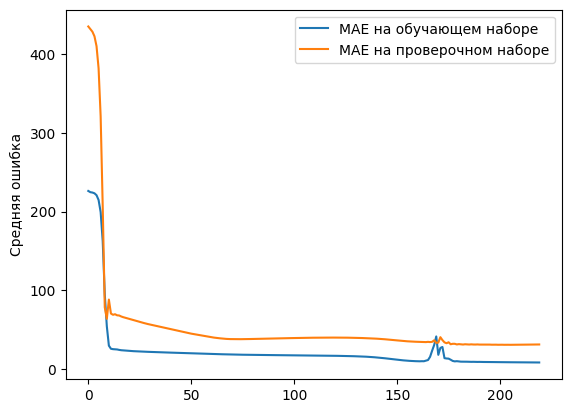

In [27]:
for iteration in range(num_iterations):
  history_1 = model_1.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_1.extend(history_1.history['val_mae'][:])
  hist_train_1.extend(history_1.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_1, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_1, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [28]:
pred_1 = model_1.predict(dataset_train).flatten()
pred_val_1 = model_1.predict(dataset_val).flatten()

5/5 [==============================] - 0s 1ms/step


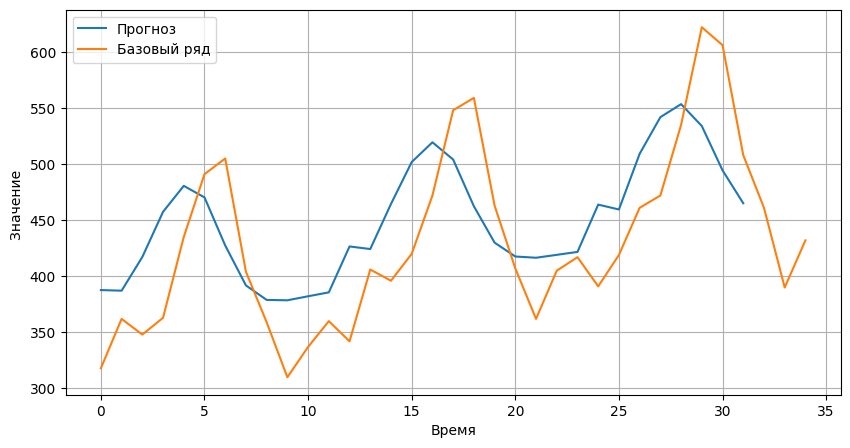

In [29]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

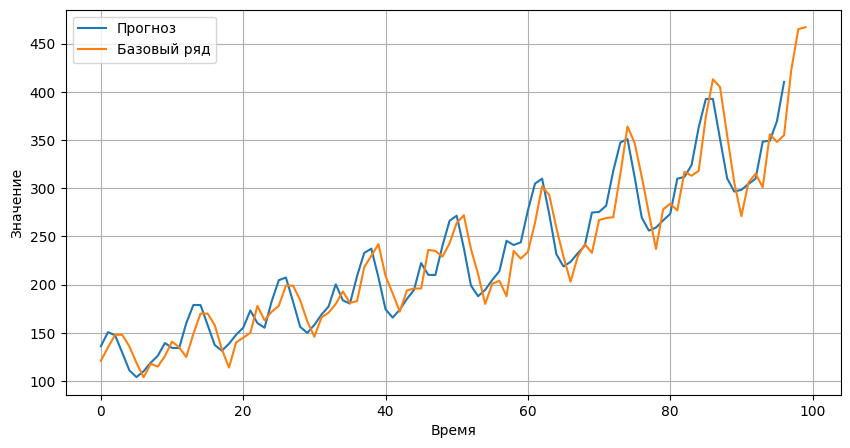

In [30]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [31]:
train_loss_1, train_m_1 = model_1.evaluate(dataset_train)
test_loss_1, test_m_1 = model_1.evaluate(dataset_val)
print(f'train_loss: {train_loss_1}, train_m: {train_m_1}')
print(f'test_loss: {test_loss_1}, test_m: {test_m_1}')

model.append('SimpleRNN')
train_m.append(round(train_m_1,2))
test_m.append(round(test_m_1,2))

5/5 [==============================] - 0s 2ms/step - loss: 1348.8848 - mae: 31.1483
train_loss: 100.84131622314453, train_m: 7.8583197593688965
test_loss: 1348.884765625, test_m: 31.148256301879883


**LSTM**

In [32]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_2 = Sequential()

model_2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_2.add(LSTM(32, return_sequences=True))
model_2.add(Conv1D(64, 3, activation='linear'))
model_2.add(Conv1D(64, 1, activation='linear'))
model_2.add(Flatten())
model_2.add(Dense(3, activation='linear'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4480      
                                                                 
 lstm_1 (LSTM)               (None, 3, 32)             8320      
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
 dense_3 (Dense)             (None, 1)                

In [33]:
history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 4s 67ms/step - loss: 56616.6133 - mae: 225.5586 - val_loss: 193000.3125 - val_mae: 431.9956
Epoch 2/10
13/13 [==============================] - 0s 9ms/step - loss: 56125.9805 - mae: 224.5201 - val_loss: 191579.3281 - val_mae: 430.3558
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 54649.3320 - mae: 221.5069 - val_loss: 186552.6875 - val_mae: 424.5178
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 49573.6016 - mae: 210.9128 - val_loss: 168516.9375 - val_mae: 402.9466
Epoch 5/10
13/13 [==============================] - 0s 9ms/step - loss: 34245.3008 - mae: 175.1060 - val_loss: 113552.1094 - val_mae: 328.8584
Epoch 6/10
13/13 [==============================] - 0s 9ms/step - loss: 6399.6816 - mae: 70.7816 - val_loss: 21720.1875 - val_mae: 132.4563
Epoch 7/10
13/13 [==============================] - 0s 9ms/step - loss: 6430.2212 - mae: 64.2529 - val_loss: 9705.2217 - val_mae: 78.6722
Epoch 

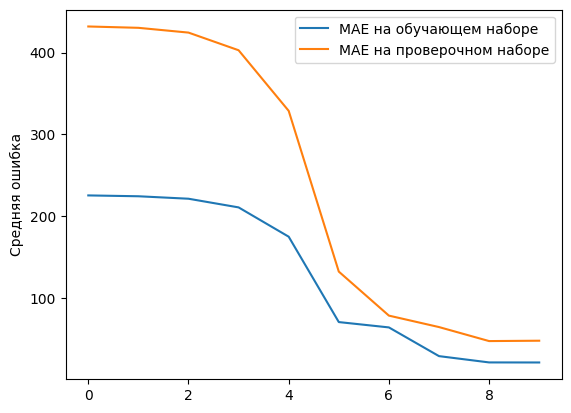

In [34]:
plt.plot(history_2.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_2.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [35]:
hist_val_2 = history_2.history['val_mae']
hist_train_2 = history_2.history['mae']

In [36]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 8ms/step - loss: 720.1878 - mae: 21.1936 - val_loss: 4459.8164 - val_mae: 48.1998
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 708.2432 - mae: 20.8354 - val_loss: 4337.9302 - val_mae: 47.6141
Epoch 3/10
13/13 [==============================] - 0s 9ms/step - loss: 692.4269 - mae: 20.2419 - val_loss: 4453.6777 - val_mae: 48.1763
Epoch 4/10
13/13 [==============================] - 0s 9ms/step - loss: 685.0083 - mae: 20.0877 - val_loss: 4324.4453 - val_mae: 47.5051
Epoch 5/10
13/13 [==============================] - 0s 9ms/step - loss: 677.8890 - mae: 19.9338 - val_loss: 4264.2329 - val_mae: 47.2128
Epoch 6/10
13/13 [==============================] - 0s 9ms/step - loss: 671.7770 - mae: 19.8528 - val_loss: 4178.3359 - val_mae: 46.7815
Epoch 7/10
13/13 [==============================] - 0s 9ms/step - loss: 666.4487 - mae: 19.7629 - val_loss: 4109.4609 - val_mae: 46.4291
Epoch 8/10
13/13 [=======================

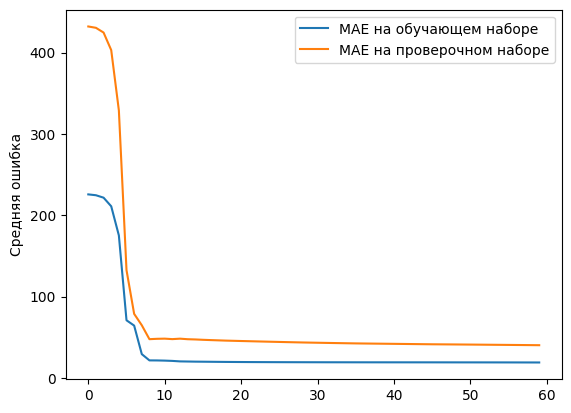

Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 571.8193 - mae: 18.8810 - val_loss: 2756.4062 - val_mae: 40.0453
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 569.7536 - mae: 18.8563 - val_loss: 2738.7170 - val_mae: 39.9459
Epoch 3/10
13/13 [==============================] - 0s 9ms/step - loss: 567.5939 - mae: 18.8294 - val_loss: 2720.9365 - val_mae: 39.8426
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 565.3320 - mae: 18.7999 - val_loss: 2703.0283 - val_mae: 39.7351
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 562.9594 - mae: 18.7678 - val_loss: 2684.9473 - val_mae: 39.6233
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 560.4679 - mae: 18.7328 - val_loss: 2666.6545 - val_mae: 39.5067
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 557.8472 - mae: 18.6948 - val_loss: 2648.1077 - val_mae: 39.3850
Epoch 8/10
13/13 [=================

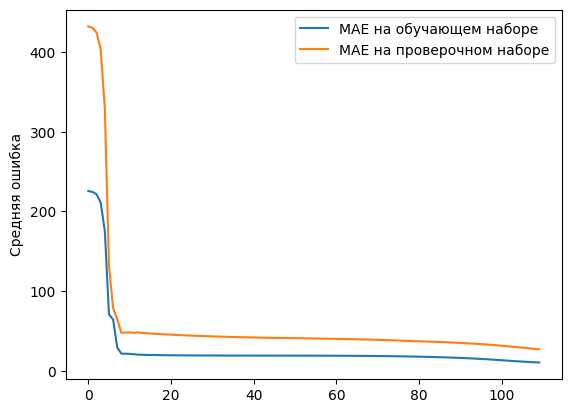

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 171.6262 - mae: 10.2250 - val_loss: 961.4314 - val_mae: 26.4182
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 166.8446 - mae: 10.0546 - val_loss: 933.4224 - val_mae: 25.9536
Epoch 3/10
13/13 [==============================] - 0s 9ms/step - loss: 162.8863 - mae: 9.9318 - val_loss: 908.9018 - val_mae: 25.5377
Epoch 4/10
13/13 [==============================] - 0s 9ms/step - loss: 159.6390 - mae: 9.8215 - val_loss: 887.6402 - val_mae: 25.2122
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 156.9909 - mae: 9.7236 - val_loss: 869.3513 - val_mae: 24.9393
Epoch 6/10
13/13 [==============================] - 0s 10ms/step - loss: 154.8357 - mae: 9.6400 - val_loss: 853.7561 - val_mae: 24.7209
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 153.0783 - mae: 9.5799 - val_loss: 840.5686 - val_mae: 24.5261
Epoch 8/10
13/13 [==============================

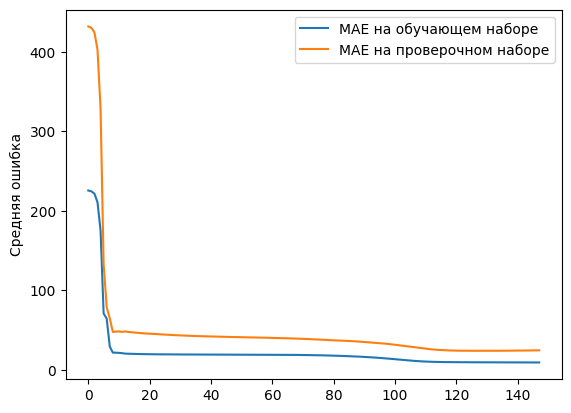

Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 137.0048 - mae: 9.0801 - val_loss: 818.9320 - val_mae: 24.4562
Epoch 2/10
13/13 [==============================] - 0s 9ms/step - loss: 136.7438 - mae: 9.0716 - val_loss: 821.6661 - val_mae: 24.5214
Epoch 3/10
13/13 [==============================] - 0s 9ms/step - loss: 136.4895 - mae: 9.0641 - val_loss: 824.4559 - val_mae: 24.5857
Epoch 4/10
13/13 [==============================] - 0s 9ms/step - loss: 136.2418 - mae: 9.0569 - val_loss: 827.2759 - val_mae: 24.6487
Epoch 5/10
13/13 [==============================] - 0s 9ms/step - loss: 136.0004 - mae: 9.0496 - val_loss: 830.1262 - val_mae: 24.7104
Epoch 6/10
13/13 [==============================] - 0s 10ms/step - loss: 135.7643 - mae: 9.0425 - val_loss: 833.0419 - val_mae: 24.7717
Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 135.5330 - mae: 9.0357 - val_loss: 836.0576 - val_mae: 24.8331
Epoch 2/10
13/13 [==============================] - 0

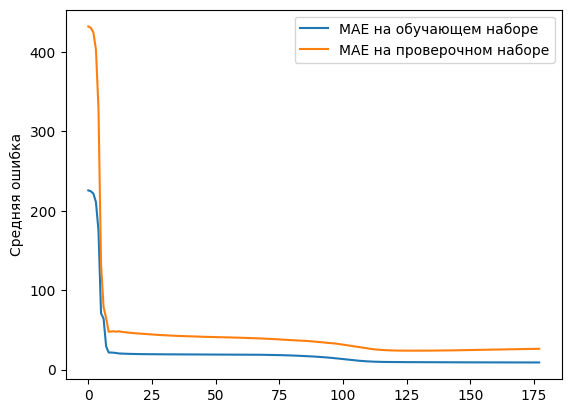

Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 131.2165 - mae: 8.9017 - val_loss: 924.0359 - val_mae: 26.1951
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 131.2618 - mae: 8.8726 - val_loss: 923.2385 - val_mae: 26.1687
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 131.3700 - mae: 8.8502 - val_loss: 921.4510 - val_mae: 26.1271
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 131.2148 - mae: 8.8545 - val_loss: 923.3695 - val_mae: 26.1458
Epoch 5/10
13/13 [==============================] - 0s 11ms/step - loss: 130.7628 - mae: 8.9042 - val_loss: 933.1332 - val_mae: 26.2903
Epoch 6/10
13/13 [==============================] - 0s 9ms/step - loss: 130.6130 - mae: 8.9713 - val_loss: 950.5975 - val_mae: 26.5476
Epoch 7/10
13/13 [==============================] - 0s 9ms/step - loss: 130.7439 - mae: 8.9991 - val_loss: 968.4348 - val_mae: 26.7904
Epoch 8/10
13/13 [==============================] -

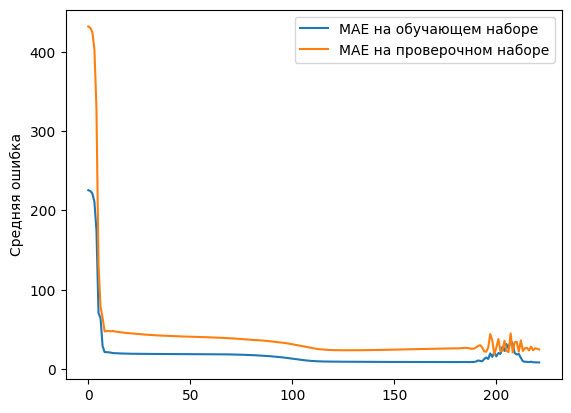

In [37]:
for iteration in range(num_iterations):
  history_2 = model_2.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_2.extend(history_2.history['val_mae'][:])
  hist_train_2.extend(history_2.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_2, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_2, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [38]:
pred_2 = model_2.predict(dataset_train).flatten()
pred_val_2 = model_2.predict(dataset_val).flatten()

5/5 [==============================] - 0s 3ms/step


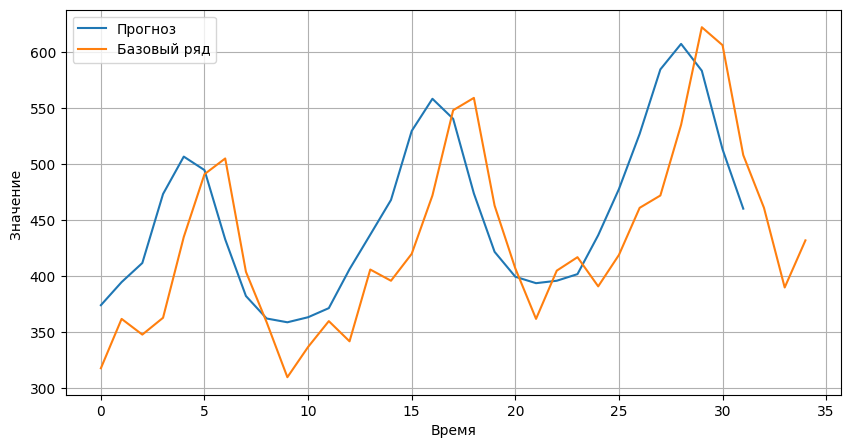

In [39]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

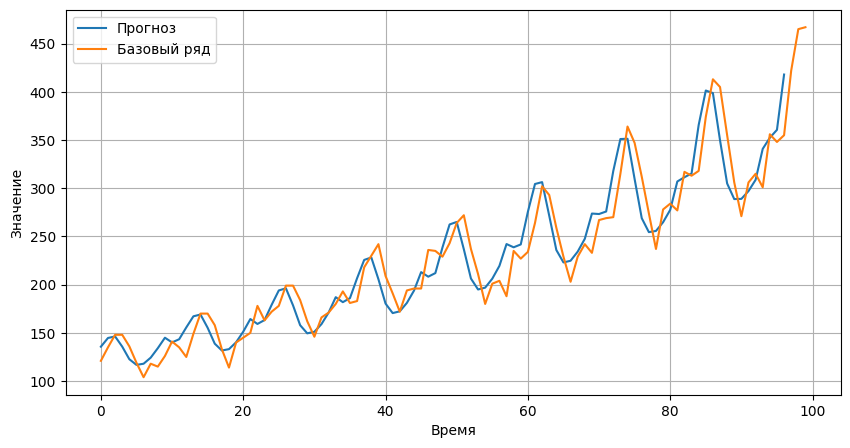

In [40]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [41]:
train_loss_2, train_m_2 = model_2.evaluate(dataset_train)
test_loss_2, test_m_2 = model_2.evaluate(dataset_val)
print(f'train_loss: {train_loss_2}, train_m: {train_m_2}')
print(f'test_loss: {test_loss_2}, test_m: {test_m_2}')

model.append('LSTM')
train_m.append(round(train_m_2,2))
test_m.append(round(test_m_2,2))

5/5 [==============================] - 0s 2ms/step - loss: 894.8798 - mae: 24.7988
train_loss: 109.54996490478516, train_m: 8.133946418762207
test_loss: 894.8797607421875, test_m: 24.798757553100586


**GRU**

In [42]:
# установка ряда метапареметров  для нейронной сети и процесса тренировки
batch_size = 8
hidden_size = 32
num_iterations = 25 
num_epochs = 1
num_preds = 100

In [43]:
model_3 = Sequential()

model_3.add(
    GRU(
        hidden_size,
        return_sequences=True,
        input_shape=(inputs.shape[1], inputs.shape[2]),
        unroll=False
    )
)
model_3.add(Conv1D(64, 3, activation='linear'))
model_3.add(Conv1D(64, 1, activation='linear'))
model_3.add(Flatten())
model_3.add(Dense(3, activation='linear'))
model_3.add(Dense(1, activation='linear'))

model_3.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 32)             3456      
                                                                 
 conv1d_4 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
 dense_5 (Dense)             (None, 1)                 4         
                                                                 
Total params: 14,023
Trainable params: 14,023
Non-trai

In [44]:
history_3 = model_3.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 2s 39ms/step - loss: 56777.3320 - mae: 225.8093 - val_loss: 193874.2500 - val_mae: 433.0011
Epoch 2/10
13/13 [==============================] - 0s 9ms/step - loss: 56538.4336 - mae: 225.2946 - val_loss: 193013.2969 - val_mae: 432.0349
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 56296.5508 - mae: 224.8893 - val_loss: 191690.5469 - val_mae: 430.5571
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 55673.7109 - mae: 223.7769 - val_loss: 188445.9531 - val_mae: 426.9144
Epoch 5/10
13/13 [==============================] - 0s 9ms/step - loss: 53825.6797 - mae: 220.3595 - val_loss: 179222.7812 - val_mae: 416.3492
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 48420.8477 - mae: 209.7994 - val_loss: 153778.8125 - val_mae: 385.5120
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 34630.1953 - mae: 178.7856 - val_loss: 95188.1250 - val_mae: 301.9321

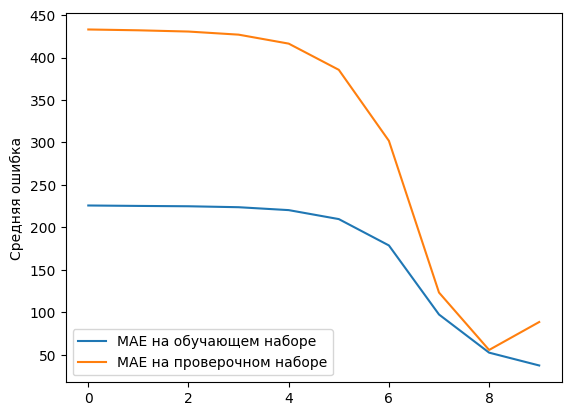

In [45]:
plt.plot(history_3.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_3.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [46]:
hist_val_3 = history_3.history['val_mae']
hist_train_3 = history_3.history['mae']

Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 970.9185 - mae: 24.6775 - val_loss: 7603.0586 - val_mae: 65.8779
Epoch 2/10
13/13 [==============================] - 0s 7ms/step - loss: 898.8098 - mae: 23.3585 - val_loss: 6794.7266 - val_mae: 61.5189
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 771.3978 - mae: 21.6248 - val_loss: 7382.7949 - val_mae: 64.2128
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 765.7413 - mae: 21.7875 - val_loss: 6755.2563 - val_mae: 61.1893
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 764.2924 - mae: 21.7231 - val_loss: 6696.2642 - val_mae: 60.9177
Epoch 6/10
13/13 [==============================] - 0s 9ms/step - loss: 747.6929 - mae: 21.4692 - val_loss: 6643.7593 - val_mae: 60.6744
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 742.8639 - mae: 21.4212 - val_loss: 6477.3423 - val_mae: 59.8340
Epoch 8/10
13/13 [======================

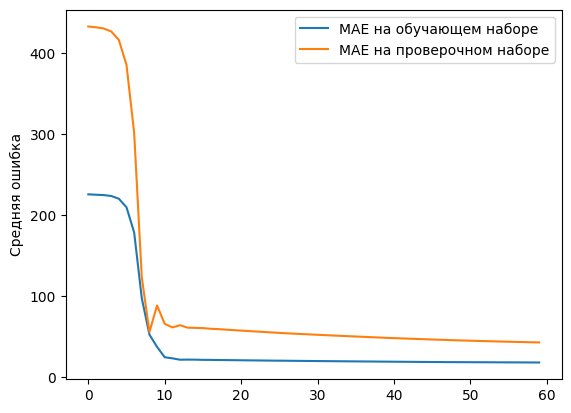

Epoch 1/10
13/13 [==============================] - 0s 8ms/step - loss: 548.3391 - mae: 18.1953 - val_loss: 3591.4575 - val_mae: 42.8134
Epoch 2/10
13/13 [==============================] - 0s 9ms/step - loss: 546.8166 - mae: 18.1646 - val_loss: 3563.5828 - val_mae: 42.6393
Epoch 3/10
13/13 [==============================] - 0s 11ms/step - loss: 545.3683 - mae: 18.1344 - val_loss: 3536.8176 - val_mae: 42.4689
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 543.9893 - mae: 18.1064 - val_loss: 3511.1050 - val_mae: 42.3022
Epoch 5/10
13/13 [==============================] - 0s 9ms/step - loss: 542.6741 - mae: 18.0804 - val_loss: 3486.4009 - val_mae: 42.1389
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 541.4174 - mae: 18.0548 - val_loss: 3462.6445 - val_mae: 41.9791
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 540.2141 - mae: 18.0296 - val_loss: 3439.7910 - val_mae: 41.8227
Epoch 8/10
13/13 [=====================

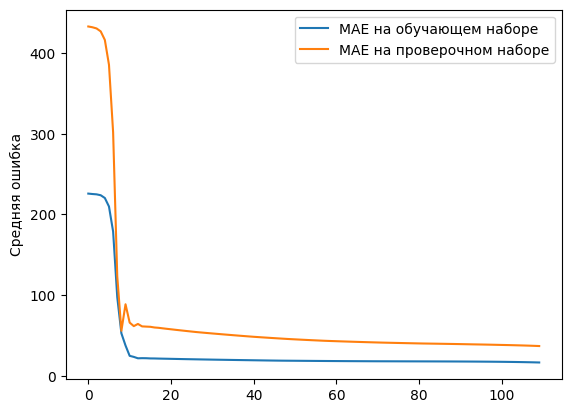

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 439.5949 - mae: 16.3046 - val_loss: 2567.6597 - val_mae: 36.6285
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 431.9898 - mae: 16.1522 - val_loss: 2530.7366 - val_mae: 36.4412
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 423.9021 - mae: 15.9859 - val_loss: 2492.1399 - val_mae: 36.2355
Epoch 4/10
13/13 [==============================] - 0s 9ms/step - loss: 415.3427 - mae: 15.8055 - val_loss: 2451.9265 - val_mae: 36.0107
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 406.3312 - mae: 15.6265 - val_loss: 2410.1829 - val_mae: 35.7665
Epoch 6/10
13/13 [==============================] - 0s 7ms/step - loss: 396.8954 - mae: 15.4469 - val_loss: 2367.0244 - val_mae: 35.5027
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 387.0714 - mae: 15.2556 - val_loss: 2322.5977 - val_mae: 35.2198
Epoch 8/10
13/13 [=====================

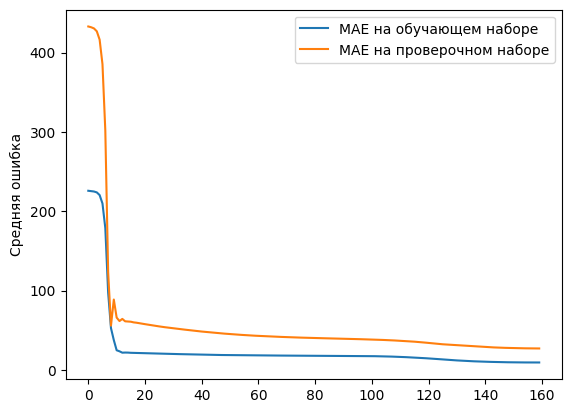

Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 138.9434 - mae: 9.2611 - val_loss: 1039.6781 - val_mae: 26.9621
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 138.2282 - mae: 9.2489 - val_loss: 1036.4686 - val_mae: 26.9856
Epoch 3/10
13/13 [==============================] - 0s 7ms/step - loss: 137.5402 - mae: 9.2363 - val_loss: 1033.8992 - val_mae: 27.0104
Epoch 4/10
13/13 [==============================] - 0s 9ms/step - loss: 136.8658 - mae: 9.2238 - val_loss: 1031.9979 - val_mae: 27.0378
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 136.2067 - mae: 9.2144 - val_loss: 1030.8517 - val_mae: 27.0694
Epoch 6/10
13/13 [==============================] - 0s 9ms/step - loss: 135.5659 - mae: 9.2036 - val_loss: 1030.1163 - val_mae: 27.1000
Epoch 1/10
13/13 [==============================] - 0s 8ms/step - loss: 134.9288 - mae: 9.1915 - val_loss: 1030.1410 - val_mae: 27.1355
Epoch 2/10
13/13 [=============================

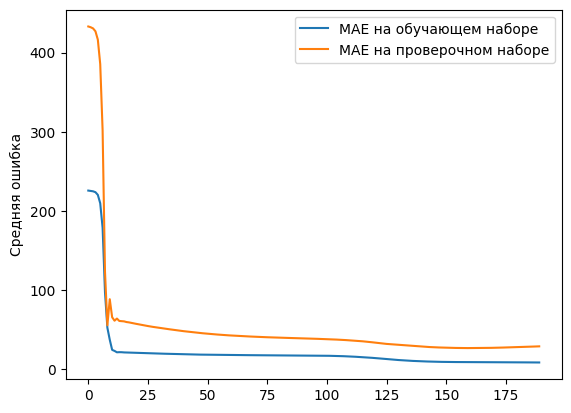

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 122.0829 - mae: 8.7472 - val_loss: 1145.2291 - val_mae: 29.2442
Epoch 2/10
13/13 [==============================] - 0s 9ms/step - loss: 121.6308 - mae: 8.7257 - val_loss: 1153.5249 - val_mae: 29.3578
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 121.1852 - mae: 8.7041 - val_loss: 1161.8546 - val_mae: 29.4928
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 120.7451 - mae: 8.6835 - val_loss: 1170.5023 - val_mae: 29.6285
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 120.3117 - mae: 8.6635 - val_loss: 1179.2496 - val_mae: 29.7620
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 119.8838 - mae: 8.6434 - val_loss: 1188.2179 - val_mae: 29.8950
Epoch 1/10
13/13 [==============================] - 0s 8ms/step - loss: 119.4622 - mae: 8.6246 - val_loss: 1197.3452 - val_mae: 30.0268
Epoch 2/10
13/13 [=============================

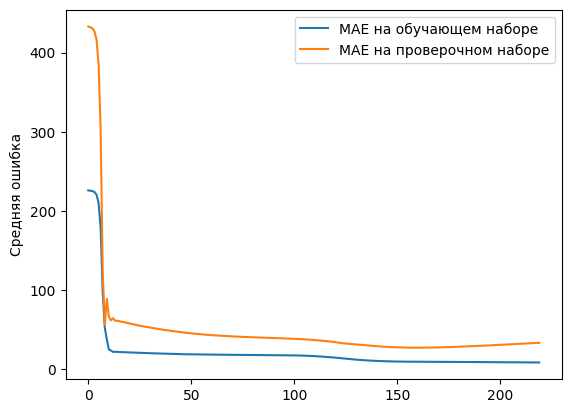

In [47]:
for iteration in range(num_iterations):
  history_3 = model_3.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_3.extend(history_3.history['val_mae'][:])
  hist_train_3.extend(history_3.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_3, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_3, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [48]:
pred_3 = model_3.predict(dataset_train).flatten()
pred_val_3 = model_3.predict(dataset_val).flatten()

5/5 [==============================] - 0s 2ms/step


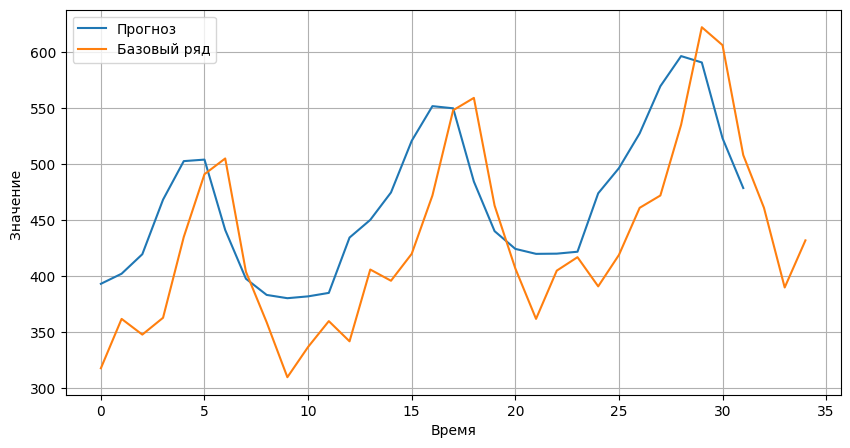

In [49]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_3[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

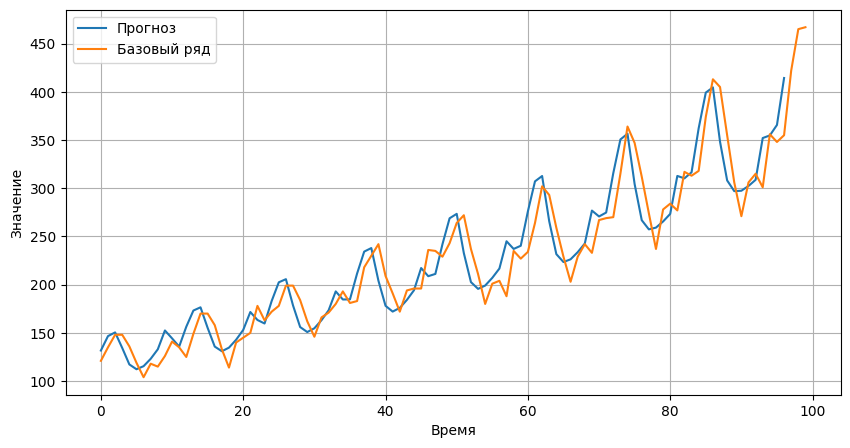

In [50]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_3[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [51]:
train_loss_3, train_m_3 = model_3.evaluate(dataset_train)
test_loss_3, test_m_3 = model_3.evaluate(dataset_val)
print(f'train_loss: {train_loss_3}, train_m: {train_m_3}')
print(f'test_loss: {test_loss_3}, test_m: {test_m_3}')

model.append('GRU')
train_m.append(round(train_m_3,2))
test_m.append(round(test_m_3,2))

5/5 [==============================] - 0s 2ms/step - loss: 1440.5800 - mae: 33.1532
train_loss: 98.3939208984375, train_m: 7.764294147491455
test_loss: 1440.5799560546875, test_m: 33.15324020385742


Общий результат

In [52]:
results['model'] = model
results['train_m'] = train_m
results['test_m'] = test_m

In [53]:
results

,model,train_m,test_m
0,SimpleRNN,7.86,31.15
1,LSTM,8.13,24.80
2,GRU,7.76,33.15


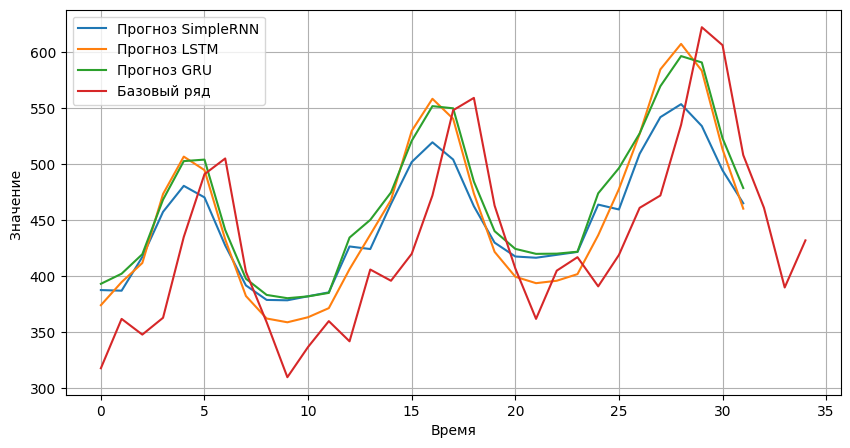

In [54]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз SimpleRNN')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз LSTM')
plt.plot(pred_val_3[future + start: future + start + step], 
         label='Прогноз GRU')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

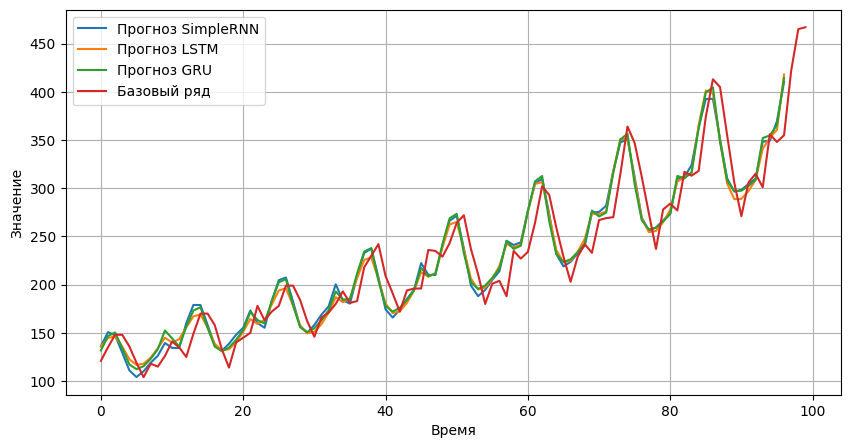

In [55]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз SimpleRNN')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз LSTM')
plt.plot(pred_3[future + start: future + train_size], 
         label='Прогноз GRU')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

**Выводы: **<br>
* чем больше итераций - тем выше качество (25 и правда хватает)
* для данного датасета лучше справился GRU, хотя LSTM сравним с ним по качеству